Download link to the [Notebook](https://github.com/UntangleAI/example/blob/master/imagenet_actlearn_tutorial.ipynb)

Download link to the [pretrained modified_vgg16 torch weights](https://untanglemodels.s3.amazonaws.com/vgg16_imgnet20_pretrained.pth)

Download link to the [Modified ImageNet20 Dataset](https://untangle-datasets.s3-ap-southeast-1.amazonaws.com/restricted_imagenet20_al_validation.zip)

## Active Learning (re-training) tutorial on Restricted ImageNet (20 classes)

#### Step 0 - Objective definition
We want to demonstrate the effect of uncertainty modelling on model performance. Specifically, we find the most meaningful unseen examples, that, when added to the training dataset, result in largest performance improvement compared to random selection. This re-training strategy can be classified into three cases:

* `uncertainty sampling`: Find the most uncertain examples in the unseen dataset (in our case the `valid` dataset), put it back in the training data and re-train model from scratch.
* `random sampling`: Select random samples from the unseen dataset (in our case the `valid` dataset), put it back in the training and re-train model from scratch.
* `inverse uncertainty sampling` (for comparison): Find the least uncertain (highly confident) examples in the `valid` dataset, put it back in the training data and re-train model from scratch

#### Step 1 - Load necessary modules

In [1]:
import os
import torch
torch.set_printoptions(precision=8)
from untangle import UntangleAI
untangle_ai = UntangleAI()
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models.custom_vgg import CustomVgg16 # we have modified VGG16 to output 20 class probabilities
import pickle
import shutil
import numpy as np
import math
import random
from datetime import datetime
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.backends.backend_pdf import PdfPages

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(42)

#### Step 2 - Provide necessary arguments to perform active learning.

* `mname` [`<class str>`] - base name / prefix to generate visualization files
* `batch_size` [`<class int>`, `default:64`] - batch size to train model for accuracy and rank unseen data for uncertainty. We observed that a Tesla K80, 12Gb GPU can accommodate a batch size of `64` for a standard (224,224) RGB image for accuracy training.
* `num_classes` [`<class int>`] - number of classes in the dataset
* `sample_selection` [`<class float>`] - train-validation split of the training data. Since we use the `valid` data folder as the unseen data, we create a split from the training data for validation
* `mode` [`<class str>`, default:uncertain] - unseen sample selection from the unseen data folder (in our case the `valid` data folder)

In [2]:
class Args:
    # choices: `vgg16_imgnet20_uncertain_retrain`, `vgg16_imgnet20_random_retrain`, `vgg16_imgnet20_certain_retrain`
    mname = 'vgg16_imgnet20_uncertain_retrain'
    data_name = 'imagenet20_data'
    batch_size = 64
    num_classes = 20
    img_size = (3,224,224)
    metric = 'prob' # for future additions. Current default set to `prob`
    num_epochs = 300
    patience = 10
    lr = 0.001
    sample_selection = 0.2 # 20% of unseen data
    is_al = False # set it to True for active learning - computing uncertainty repeatedly with increasing labelled data
    mode = 'uncertain' # one of `uncertain`, `certain`, `random`

#### Step 3 - Define data / models paths and class name to index mapping


* `dataset_path`: Since we will me manipulating the dataset folder by moving images from unseen (`valid`) folder to the `train` folder, we create a copy of the dataset so as to not corrupt the original data
* `al_validation_path`: path to save model training and re-training history (loss and accuracy)

In [3]:
args = Args()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
module_path = os.path.abspath('')
data_path = os.path.join(module_path, 'data')
src_data_path = os.path.join(data_path, 'imagenet20_data')
curr_time_path = 'imagenet20_data_' + datetime.now().strftime("%Y%m%d_%H%M%S")
dataset_path = os.path.join(data_path, curr_time_path) # copy of the data
al_validation_path = os.path.join(module_path, '{}_history.pkl'.format(args.mname))

#### Step 4 - Create an instance of torch model and define transforms to be applied to the data

In [4]:
model = CustomVgg16(num_classes=args.num_classes, use_pretrained=False)
model = model.to(DEVICE)

in_transform = transforms.Compose([
    transforms.Resize((args.img_size[1]+32, args.img_size[2]+32)),
    transforms.CenterCrop((args.img_size[1], args.img_size[2])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

#### Step 5 - Define utility functions to be used to move data to across directories

In [5]:
def update_labelled_data_pool(img_list, dst_data_path):
    '''
    Move a list of images to a specified path
    :param img_list: list of image paths
    :param dst_data_path: destination directory to move images to
    :return: None
    '''
    for img_i_path in img_list:
        target = img_i_path.split('/')[-2].strip()
        dst_img_dir = os.path.join(dst_data_path, str(target))

        if(not os.path.exists(dst_img_dir)):
            os.makedirs(dst_img_dir)
        shutil.move(img_i_path, dst_img_dir)

In [6]:
def move_random_examples(src_data_path, dst_data_path, num_examples=1000):
    '''
    Move random `num_examples` number of images from source dir to destination dir
    :param src_data_path: source directory containing images
    :param dst_data_path: destination directory containing images
    :param num_examples: number of images to move
    :return: None
    '''
    
    subdirs = [x[0] for x in os.walk(src_data_path)][1:]
    num_classes = len(subdirs)
    sample_counts = [int(num_examples / num_classes) for _ in range(num_classes)]
    offset = num_examples - sum(sample_counts)
    for idx, val in enumerate([1] * offset):
        sample_counts[idx] += val

    for subdir, sample_count in zip(subdirs, sample_counts):
        subdir_name = subdir.split('/')[-1].strip()
        all_files = os.listdir(subdir)
        sampled_files = random.sample(all_files, sample_count)
        src_subdir_path = os.path.join(src_data_path, subdir_name)
        dst_subdir_path = os.path.join(dst_data_path, subdir_name)
        if(not os.path.exists(dst_subdir_path)):
            os.makedirs(dst_subdir_path)

        for fname in sampled_files:
            src_file = os.path.join(src_subdir_path, fname)
            dst_file = os.path.join(dst_subdir_path, fname)
            shutil.move(src_file, dst_file)

#### Step 6 - Create a copy of the dataset and get data_loaders

In [7]:
os.system("cp -r {} {}".format(src_data_path, dataset_path))
train_path = os.path.join(dataset_path, 'train')
pool_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')  # custom created: half of validation data selected at random
base_model_path = os.path.join(module_path, 'models')
if(not os.path.exists(base_model_path)):
    os.makedirs(base_model_path)
model_ckpt_path = os.path.join(base_model_path, '{}.pth'.format(args.mname))

train_loader, val_loader = untangle_ai.load_from_dir(train_path, batch_size=args.batch_size, transform=in_transform,
                                                  shuffle=False, get_paths=False,
                                                  val_split=True)  # val_split shuffles automatically
test_loader, n_images = untangle_ai.load_from_dir(test_path, batch_size=args.batch_size, transform=in_transform,
                                     shuffle=False, get_paths=False, get_img_count=True)

#### Step 7 - Define training loop for model training with learning rate schedule at patience as follows:

* When no reduction is validation loss for `patience` number of epochs, reduce learning rate by `0.2` (users can configure it to a suitable number as desired)
* When no reduction in validation loss for `5 x patience` number of epochs, then we early stop the training loop.

In [8]:
class EarlyStopping:
    def __init__(self, patience, save_path, msg):
        self.patience = patience
        self.save_path = save_path
        self.min_loss = 100000.0 # some high number
        self.min_acc = 0.0 # some low number
        self.curr_patience = 0
        self.optimal_params = None # deepcopy(model.state_dict())
        self.msg = msg

    def __call__(self, curr_loss, model):
        if(curr_loss < self.min_loss):
            self.min_loss = curr_loss
            self.optimal_params = deepcopy(model.state_dict())
            self.curr_patience = 0
            return(False)
        else:
            self.curr_patience += 1
            if(self.curr_patience == self.patience):
                print(self.msg)
                if(self.save_path is not None):
                    torch.save(model.state_dict(), self.save_path)
                    print("Model saved in path: {}".format(self.save_path))
                return(True)

    def reset_patience(self):
        self.curr_patience = 0

class AdjustLR:
    def __init__(self, lr):
        self.lr = lr
    def __call__(self, optimizer, decay_rate=0.2):
        print("Updating Learning Rate from [{}] to [{}]".format(self.lr, self.lr*decay_rate))
        self.lr *= decay_rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = self.lr * decay_rate

def train_with_patience(base_model, train_loader, val_loader, test_loader, lr=0.001, max_epochs=50,
           patience=10, print_freq=40, save_model_path=None):
    base_model.train()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=lr, weight_decay=1e-4)
    patience_reached = EarlyStopping(patience=patience, save_path=save_model_path, msg='Patience Reached! Reducing LR!!')
    early_stopping = EarlyStopping(patience=5*patience, save_path=save_model_path, msg='No update since {} epochs. EarlyStopping!!'.format(5*patience))
    adjustLR = AdjustLR(lr)
    break_flag = False

    acc_history = dict()
    acc_history['train'] = []
    acc_history['val'] = []
    acc_history['test'] = []
    loss_history = dict()
    loss_history['train'] = []
    loss_history['val'] = []
    loss_history['test'] = []
    for epoch in range(max_epochs):
        torch.cuda.empty_cache()
        if(not break_flag):
            for mode in ['train', 'val']:
                running_loss = 0.0; running_corrects = 0.0; counts = 0
                if(mode == 'train'):
                    base_model.train()
                    data_loader = train_loader
                else:
                    base_model.eval()
                    data_loader = val_loader

                for step, (input_tensor, target) in enumerate(data_loader):
                    input_tensor = input_tensor.cuda()
                    target = target.cuda()
                    optimizer.zero_grad()
                    output = base_model(input_tensor)
                    if(isinstance(output, tuple)):
                        output = output[-1] # in case of multi output, take the last (pre-sfotmax) output
                    pred = torch.max(output, 1)[1]
                    model_loss = criterion(output, target)
                    if(mode == 'train'):
                        model_loss.backward()
                        optimizer.step()
                    running_loss += model_loss.item() * input_tensor.size(0)
                    running_corrects += torch.sum(pred == target.data).item()
                    counts += input_tensor.size(0)

                    if(mode == 'train' and step % print_freq == 0):
                        print(
                            "Epoch: [{epoch}][{curr_step}/{total}] \t"
                            "train_loss: {loss} \t"
                            "train_acc: {acc}".format(
                                epoch=epoch,
                                curr_step=step+1,
                                total=len(train_loader),
                                loss=running_loss / counts,
                                acc=running_corrects / counts))

                epoch_loss = running_loss / counts
                epoch_acc = running_corrects / counts
                acc_history[mode].append(epoch_acc)
                loss_history[mode].append(epoch_loss)
                print("[{}]: loss: {} \t acc: {}".format(mode.upper(), epoch_loss, epoch_acc))

                if(mode == 'val'):
                    if(patience_reached(epoch_loss, base_model)):
                        base_model.load_state_dict(patience_reached.optimal_params)
                        adjustLR(optimizer, decay_rate=0.25)

                    if(early_stopping(epoch_loss, base_model)):
                        break_flag = True

    # Validation conf matrix
    base_model.load_state_dict(early_stopping.optimal_params)
    _, _, val_conf_matrix = get_pred(base_model, val_loader, optimizer, criterion)
    epoch_loss, epoch_acc, test_conf_matrix = get_pred(base_model, test_loader, optimizer, criterion)
    acc_history['test'].append(epoch_acc)
    loss_history['test'].append(epoch_loss)
    print("[TEST]: loss: {} \t acc: {}".format(epoch_loss, epoch_acc))
    if(save_model_path is not None):
        torch.save(base_model.state_dict(), save_model_path)
    return(base_model, acc_history, loss_history, test_conf_matrix)

#### Step 8 - Train model for a given dataset

In [9]:
model, acc, loss, conf_matrix = train_with_patience(base_model=model, train_loader=train_loader,
                                                                    val_loader=val_loader, test_loader=test_loader,
                                                                    lr=args.lr, max_epochs=args.num_epochs,
                                                                    patience=args.patience, print_freq=50,
                                                                    save_model_path=model_ckpt_path)

#### Step 9 - Define class indices to imagenet synset mapping. For the given imagenet20 dataset, Pytorch outputs the probablity indices in range [0,19]. Hence, we need a mapping to map the [0,19] indices back to the indices in original imagenet dataset ([0,999] range)

In [10]:
synset20toID_Map = {'n01484850': '0', 'n01491361': '1', 'n02123159': '2', 'n02124075': '3', 'n02687172': '4', 'n02799071': '5',
                    'n02906734': '6', 'n02974003': '7', 'n03272010': '8', 'n03977966': '9', 'n04146614': '10', 'n04154565': '11',
                    'n04251144': '12','n04285008': '13', 'n04335435': '14', 'n04356056': '15', 'n07720875': '16',
                    'n07742313': '17', 'n07745940': '18', 'n09256479': '19'}

synset_map_path = os.path.join(data_path, 'synset_mapping.txt')
label_map_path = os.path.join(data_path, 'label_mapping.txt')
if (not os.path.exists(synset_map_path)):
    raise FileNotFoundError(synset_map_path)
if (not os.path.exists(label_map_path)):
    raise FileNotFoundError(label_map_path)

synset_df = pd.read_csv(synset_map_path, delimiter=':', names=['label', 'synset'], dtype=str)
df_obj = synset_df.select_dtypes(['object'])
synset_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
label_df = pd.read_csv(label_map_path, delimiter=':', names=['label', 'name'], dtype=str)
synset20_df = pd.DataFrame(list(synset20toID_Map.items()), columns=['synset', 'label'])

df_merge = pd.merge(synset20_df, synset_df, on='synset', how='left', validate='one_to_one')
df_merge = pd.merge(df_merge, label_df, left_on='label_y', right_on='label', how='left', validate='one_to_one')
df_obj = df_merge.select_dtypes(['object'])
df_merge[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
ID2Name_Map = dict(zip(df_merge.label_x, df_merge.name))

#### Step 10 - **Uncertainty Sampling (using our method)**: Select relevant examples from the unseen data (`valid` directory) to add back to the training dataset. 

* We use our uncertainty modelling and ranking method to find out the most uncertain examples, which, when added to the training data, result in highest accuracy jump.

In [12]:
uncertainty_base_path = os.path.join(module_path, 'model_uncertainty_data')
if(not os.path.exists(uncertainty_base_path)):
    os.makedirs(uncertainty_base_path)
uncertainty_store_path = os.path.join(uncertainty_base_path, '{}_uncertainty'.format(args.mname))
print("estimating model uncertainty for all classes...")

# Model Uncertainty on training dataset
def train_loader_fun(class_i):
    loader = untangle_ai.load_from_dir_per_class(train_path, data_class=class_i, batch_size=args.batch_size,
                                     transform=in_transform, shuffle=False, get_paths=False)
    return(loader)
model.eval()
untangle_ai.model_uncertainty(model, uncertainty_store_path, train_loader_fun, args)

estimating model uncertainty for all classes...
Estimating uncertainty for class: `0`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `0`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `1`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `1`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `2`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `2`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `3`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `3`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `4`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `4`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `5`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `6`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `7`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `7`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `8`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `8`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `9`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `9`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `10`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `11`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `11`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `12`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `12`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `13`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `13`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `14`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `14`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `15`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `15`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `16`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `16`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `17`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `17`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `18`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `18`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating uncertainty for class: `19`


  0%|          | 0/16 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `19`


100%|██████████| 16/16 [01:14<00:00,  4.63s/it]


In [12]:
class ImgPathAndTensor(datasets.ImageFolder):
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(ImgPathAndTensor, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (path, original_tuple[0])
        return tuple_with_path

# Rank Uncertainty on unseen dataset
base_uncertainty_path = os.path.join(module_path, 'model_uncertainty_data/')
if(not os.path.exists(base_uncertainty_path)):
    os.makedirs(base_uncertainty_path)
uncertainty_store_path = os.path.join(base_uncertainty_path, '{}_uncertainty'.format(args.mname))

unlabelled_set = ImgPathAndTensor(pool_path, transform=in_transform) # returns dataset that generates img_paths and img_tensors
data_loader = torch.utils.data.DataLoader(unlabelled_set, batch_size=args.batch_size, shuffle=False, num_workers=1)
ranking_df = untangle_ai.rank_data(model, data_loader, uncertainty_store_path, base_out_path=None, ID2Name_Map=ID2Name_Map, args=args)
ranking_df = ranking_df.sort_values(by=['score'], ascending=True)
num_query_instances = int(args.sample_selection * n_images) + 1 # no. of examples to select from the unseen dataset
ranking_df = ranking_df.head(num_query_instances)
uncertain_examples = list(ranking_df['img_path'])

  0%|          | 0/94 [00:00<?, ?it/s]

ranking data uncertainty...



100%|██████████| 19/19 [00:00<00:00, 158.16it/s]

computing internal statistics...



100%|██████████| 94/94 [23:30<00:00, 15.00s/it]


#### Step 11 - Plot distribution of uncertain images selected using our uncertainty modelling framework

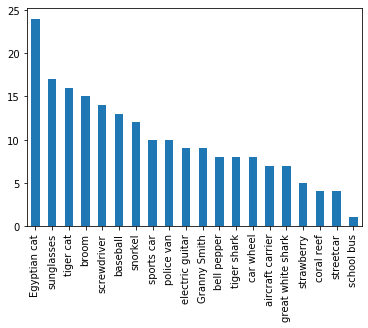

In [15]:
synsets = []
for img_path in uncertain_examples:
    synset = img_path.split('/')[-1].split('_')[0].strip()
    synsets.append(synset)

index_list = [synset20toID_Map[synset] for synset in synsets]
names_list = [ID2Name_Map[str(idx)] for idx in index_list]
pd.Series(names_list).value_counts().plot('bar')

#### Step 12 - Re-train model from scratch using the given training data + additional uncertain examples

* Merge training data directory with additional examples
* Retrain model from scratch on this new dataset

In [16]:
update_labelled_data_pool(uncertain_examples, train_path)

train_loader, val_loader = untangle_ai.load_from_dir(train_path, batch_size=args.batch_size, transform=in_transform,
                                                  shuffle=False, get_paths=False,
                                                  val_split=True)  # val_split shuffles automatically
test_loader, n_images = untangle_ai.load_from_dir(test_path, batch_size=args.batch_size, transform=in_transform,
                                     shuffle=False, get_paths=False, get_img_count=True)

model = CustomVgg16(num_classes=args.num_classes, use_pretrained=False) # reset model for re-training
model = model.to(DEVICE)
_, retrain_acc, retrain_loss, retrain_conf_matrix = train_with_patience(base_model=model, train_loader=train_loader,
                                                                  val_loader=val_loader, test_loader=test_loader,
                                                                  lr=0.1*args.lr, max_epochs=args.num_epochs,
                                                                  patience=args.patience, print_freq=50,
                                                                  save_model_path=None)

#### Step 13 - Clear up copy of the dataset and save the history is a file

In [17]:
if(os.path.exists(dataset_path)):
    shutil.rmtree(dataset_path)

validation_metric = dict()
validation_metric['acc'] = [acc, retrain_acc]
validation_metric['loss'] = [loss, retrain_loss]
validation_metric['cm'] = [conf_matrix, retrain_cm]
with open(al_validation_path, 'wb') as F:
    pickle.dump(validation_metric, F, protocol=pickle.HIGHEST_PROTOCOL)

#### Step 14 - Print training statistics, performance curves and improvements in confusion metric.

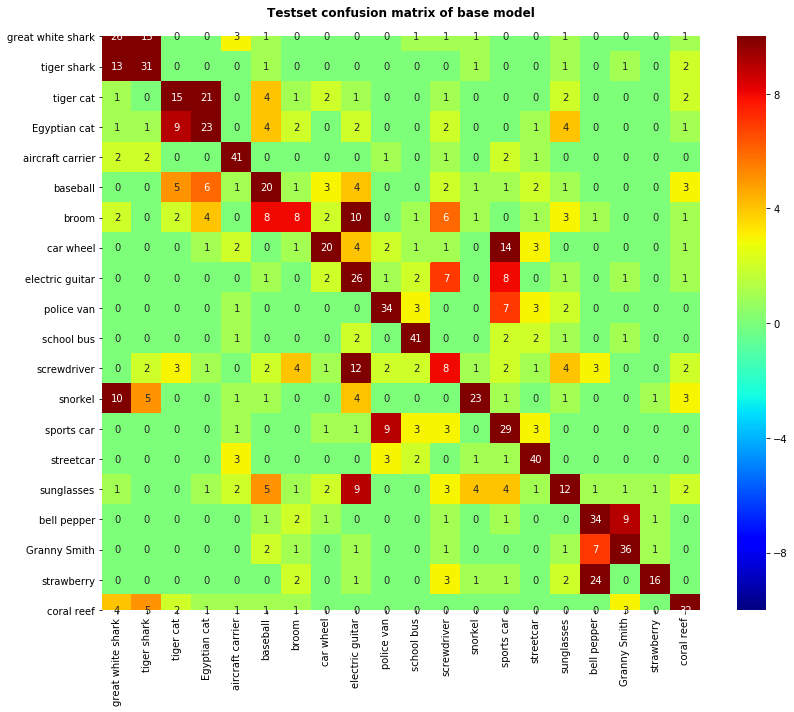

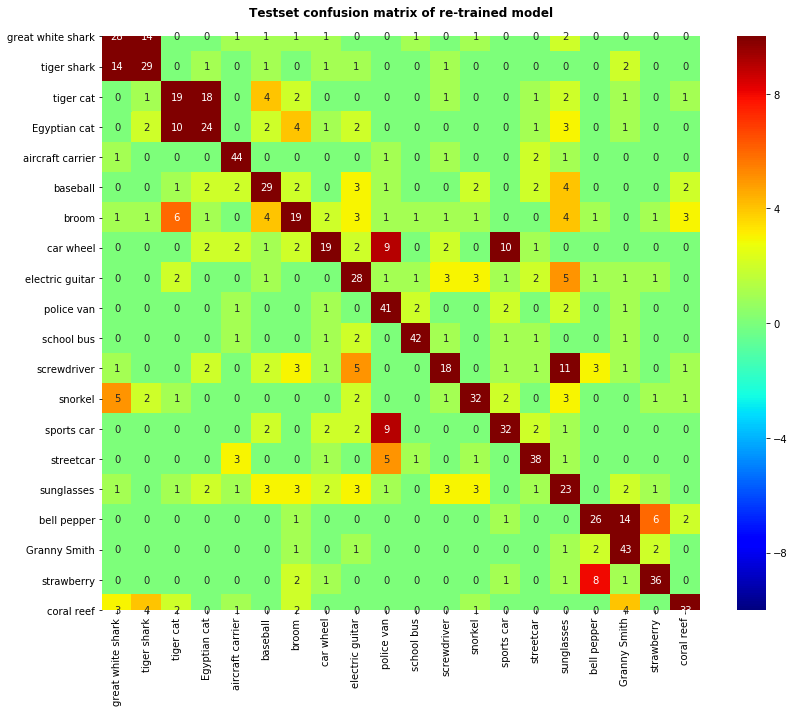

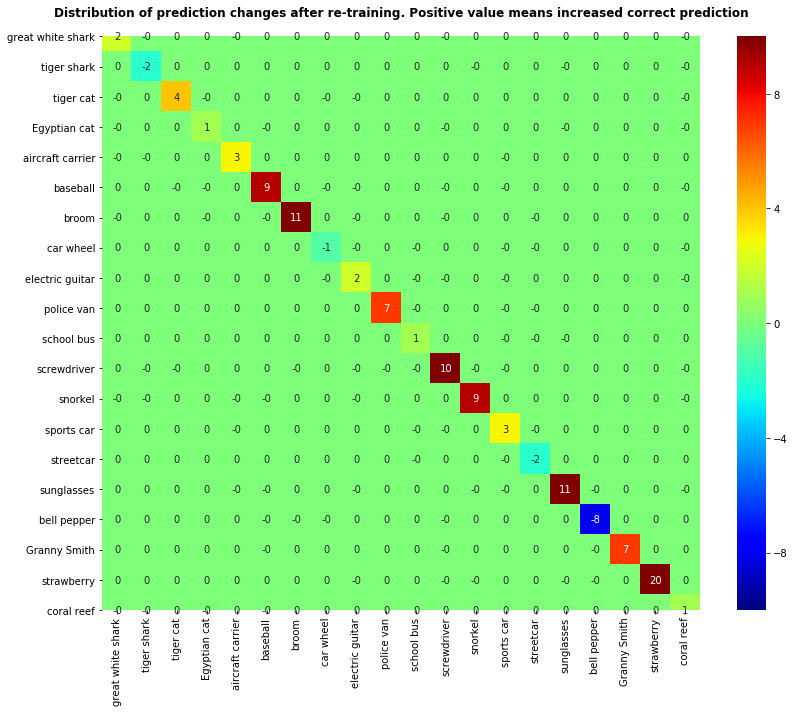

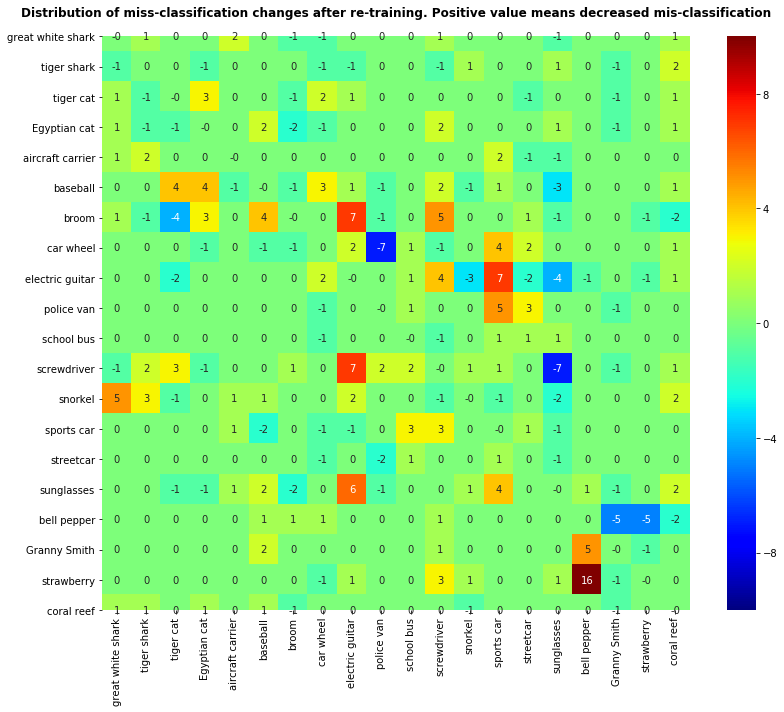

In [31]:
data = pickle.load(open(al_validation_path, 'rb'))
idx2Name_map = {'0' : 'Testset confusion matrix of base model',
                '1' : 'Testset confusion matrix of re-trained model',
                '2' : 'Distribution of prediction changes after re-training. Positive value means increased correct prediction',
                '3': 'Distribution of miss-classification changes after re-training. Positive value means decreased mis-classification'}

class_names = [ID2Name_Map[str(idx)] for idx in range(args.num_classes)]

base_df = pd.DataFrame(np.array([data['acc'][0]['train'],
                              data['acc'][0]['val'],
                              data['loss'][0]['train'],
                              data['loss'][0]['val']]).T,
                    columns=["train acc", "val acc", "train loss", "val loss"])
retrain_df = pd.DataFrame(np.array([data['acc'][1]['train'],
                              data['acc'][1]['val'],
                              data['loss'][1]['train'],
                              data['loss'][1]['val']]).T,
                    columns=["train acc", "val acc", "train loss", "val loss"])

for idx in range(len(idx2Name_map)):
    if(idx == 2):
        matrix_shape = data['cm'][1].shape[0], data['cm'][1].shape[1]
        in_data = (data['cm'][1] - data['cm'][0]) * np.eye(*matrix_shape)
    elif(idx == 3):
        matrix_shape = data['cm'][1].shape[0], data['cm'][1].shape[1]
        in_data = (data['cm'][0] - data['cm'][1]) * (np.ones(matrix_shape) - np.eye(*matrix_shape))
    else:
        in_data = data['cm'][idx]
    df_cm = pd.DataFrame(in_data, index = class_names, columns = class_names)
    fig = plt.figure(figsize = (12,10))
    ax = plt.axes()
    sn.heatmap(df_cm, annot=True, vmin=-10.0, vmax=10.0, cmap='jet')
    ax.set_title(idx2Name_map[str(idx)], fontweight="bold", pad=20)
    plt.tight_layout()